In [1]:
%%bash
pip install cartopy > /dev/null
pip install geopandas > /dev/null

# Chapter 7.3 - Vector Data Analysis

As we discussed in previous sections in this chapter, geographic data can be organized into raster and vector data. This section will be dedicated to an introduction to vector data analysis. A full treatment of this topic would require taking a [Geographic Information Systems (GIS)](https://en.wikipedia.org/wiki/Geographic_information_system) course.

As you may recall, vector data include points, polygons, and other shapes that represent a position, boundary/edge, or area. Common vector data analyses include manipulation of the geographic data itself (e.g., buffering, clipping, merging, etc.) and spatial selections (e.g., spatial joins, etc.). Your job as a Geoscientist is to figure out how to translate these basic GIS techniques into workflows that manipulate the data in a way that is physically meaninful and logical.

### Chapter 7.3.1 - Buffering

We introduced the idea of buffering in a previous section in this chapter. This process takes the original geometry and increases its extent by a distance defined by the user and controlled by the coordinate system. This process is rarely used on its own. Often, you define a buffer to *select* a subset of other geographic data. For example, imagine a situation like the [Chernobyl Nuclear Disaster](https://en.wikipedia.org/wiki/Chernobyl_disaster). The reactor failures occurred in a relatively small area (e.g., the lat/lon position of the power plant), but clearly had "influence" on a much larger area when considering potential radiation exposure.

You might also try to answer a question about [risk](https://en.wikipedia.org/wiki/Risk) for a location (e.g., your house, a school, etc.) by identifying hazards that have occurred within a certain distance of that location.

Consider the following situation: *You are an administrator for NIU. You need to decide on the relative tornado risk for NIU. You decide that you want to know how many tornadoes occurred within 25 miles (~40 km) of the university.*

Here are the raw geographic data:



In [2]:
%%bash
wget -q -nc https://www.spc.noaa.gov/wcm/data/1950-2024_actual_tornadoes.csv > /dev/null

Tornado data from the Storm Prediction Center:

In [3]:
import pandas as pd

tornadoes = pd.read_csv("1950-2024_actual_tornadoes.csv")

tornadoes

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71808,624887,2024,9,7,2024-09-07,05:58:00,3,IN,18,0,...,0.05,10,1,1,1,127,0,0,0,0
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,0.19,25,1,1,1,17,0,0,0,0
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,1.20,75,1,1,1,29,0,0,0,0
71811,624890,2024,9,9,2024-09-09,15:15:00,3,NY,36,0,...,0.10,50,1,1,1,45,0,0,0,0


NIU location:

In [4]:
from shapely.geometry import Point

niu = Point(-88.7739, 41.9342)




What are some of the considerations associated with connecting these two data sources?

1. Conversion to shapely/geopandas to use the geographic methods
2. Definition of the projection
3. Conversion to a projected coordinate system (if needed)
4. Translating the Geoscience need to a GIS workflow
5. Validating the results through visualization
6. Performing the statistical analysis on the resulting data.

**Converting the "raw" data to geopandas**

The single point is relatively straightforward. You simply need to define some attribute data using a dictionary and then set the geometry argument to the point in the `GeoDataFrame` constructor. We place `NIU` and `niu` in a `list` because the `GeoDataFrame` is expecting an `iterable` since you usually will have multiple rows of attributes and geometry.

In [5]:
import geopandas as gpd

niu = gpd.GeoDataFrame({"location": ['NIU']}, geometry=[niu])

niu

,location,geometry
0,NIU,POINT (-88.7739 41.9342)


We can do the same thing with the tornado data, except we have a lot of premade columns and rows, so the manual insertion we did in the previous step is not needed.

The complex part about this step is getting the lat/lon information into a format that `Geopandas` can use. As was the case in the previous step, this requires us to make a `list` of `Point`.

If you examine the dataset, you will note that the columns include a `slon` and `slat`. These represent the starting points of the tornadoes.

In [6]:
tornadoes[['slon', 'slat']]

,slon,slat
0,-102.5200,36.7300
1,-78.6000,34.1700
2,-87.2000,37.3700
3,-84.5000,38.2000
4,-89.1300,32.4200
...,...,...
71808,-86.9567,41.7019
71809,-108.2136,43.6457
71810,-79.0102,43.0333
71811,-75.8837,43.7565


We need to loop through these lat/lon pairs, transform each pair into a `Point`, and save that point in a list. Luckily, `Geopandas` has a method for this called [`points_from_xy`](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html).

This method expects a list of x and y points, where the x and y pairs are identified by the order they exist within the list. In other words, the `slon` at index 5 is paired with the `slat` at index 5.

We can get separate lists like this:

In [7]:
lons = tornadoes['slon']
lats = tornadoes['slat']

print("these are the lons ->", lons)
print("\nthese are the lats ->", lats)

these are the lons -> 0       -102.5200
1        -78.6000
2        -87.2000
3        -84.5000
4        -89.1300
           ...   
71808    -86.9567
71809   -108.2136
71810    -79.0102
71811    -75.8837
71812    -78.3987
Name: slon, Length: 71813, dtype: float64

these are the lats -> 0        36.7300
1        34.1700
2        37.3700
3        38.2000
4        32.4200
          ...   
71808    41.7019
71809    43.6457
71810    43.0333
71811    43.7565
71812    43.0241
Name: slat, Length: 71813, dtype: float64


and we can use `points_from_xy` like this. The result is a `GeometryArray` of `Point`, which can be used directly during the creation of a `GeoDataFrame`.

In [8]:
pts = gpd.points_from_xy(lons, lats)

pts

<GeometryArray>
[  <POINT (-102.52 36.73)>,     <POINT (-78.6 34.17)>,
     <POINT (-87.2 37.37)>,      <POINT (-84.5 38.2)>,
    <POINT (-89.13 32.42)>,     <POINT (-76.12 40.2)>,
    <POINT (-90.05 38.97)>,    <POINT (-89.67 38.75)>,
    <POINT (-91.83 36.12)>,    <POINT (-89.78 38.17)>,
 ...
  <POINT (-78.488 36.319)>,    <POINT (-81.43 30.67)>,
 <POINT (-109.875 42.638)>,  <POINT (-98.101 35.841)>,
  <POINT (-78.176 42.135)>,  <POINT (-86.957 41.702)>,
 <POINT (-108.214 43.646)>,   <POINT (-79.01 43.033)>,
  <POINT (-75.884 43.756)>,  <POINT (-78.399 43.024)>]
Length: 71813, dtype: geometry

We can even add projection information during this step by assigning a lat/lon projection to the points:

In [9]:
pts = gpd.points_from_xy(lons, lats, crs='EPSG:4269')

pts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

We can further combine this approach with the inclusion of the attribute data when we call the constructor for `GeoDataFrame`:

In [10]:
geo_tors = gpd.GeoDataFrame(
    data=tornadoes,
    geometry=gpd.points_from_xy(lons, lats, crs='EPSG:4269')
)

print("projection =", geo_tors.crs)

geo_tors

projection = EPSG:4269


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,geometry
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,10,1,1,1,25,0,0,0,0,POINT (-102.52 36.73)
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,880,1,1,1,47,0,0,0,0,POINT (-78.6 34.17)
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,10,1,1,1,177,0,0,0,0,POINT (-87.2 37.37)
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,10,1,1,1,209,0,0,0,0,POINT (-84.5 38.2)
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,37,1,1,1,101,0,0,0,0,POINT (-89.13 32.42)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71808,624887,2024,9,7,2024-09-07,05:58:00,3,IN,18,0,...,10,1,1,1,127,0,0,0,0,POINT (-86.9567 41.7019)
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,25,1,1,1,17,0,0,0,0,POINT (-108.2136 43.6457)
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,75,1,1,1,29,0,0,0,0,POINT (-79.0102 43.0333)
71811,624890,2024,9,9,2024-09-09,15:15:00,3,NY,36,0,...,50,1,1,1,45,0,0,0,0,POINT (-75.8837 43.7565)


Now, the points are converted and the projection information is assigned. You can use spatial analysis approaches!

Remember the `niu` point data? We can apply a buffer of 25 miles (40 km) by:

1. Assigning a projection
2. Transforming to an equal-area projection
3. Transforming the tornado data to the same projection
4. Running the `buffer` method
5. Running the `sjoin` method


In [12]:
# NAD 83
niu_latlon = niu.set_crs("EPSG:4269")

# Conus Albers Equal Area
niu_aea = niu_latlon.to_crs("EPSG:5070")

# 1 km = 1000 m
niu_aea.geometry = niu_aea.geometry.buffer(40000)

tor_aea = geo_tors.to_crs("EPSG:5070")

print("new projection =", niu_aea.crs)

niu_aea

new projection = EPSG:5070


,location,geometry
0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."


We now need to use a method called [`sjoin`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html).

This method takes a set of two geographic features and performs a ['spatial join'](https://en.wikipedia.org/wiki/Spatial_join). A spatial join is actually a general term for several types of checks for geographic relationships. The theme that holds all of the approaches together is the search for overlapping features in space.

In our case, we have a buffer (circle) and we want to capture all tornado reports (points) that are spatially within the buffer ('within' join).

The `sjoin` method has many parameters that are important to understand:

1. `left_df` and `right_df` - the two GeoDataFrames to be spatially joined. The order matters, but another parameter can modify the importance.

2. `how`
- `inner`: keeps `left_df` geometry, but attaches 'right_df' attributes to `left_df` for rows that meet the spatial join criteria. For rows that do not, they are discarded in both `left_df` and `right_df`.
- `right`: keeps `right_df` geometry, but attaches `left_df` attributes that meet the spatial join criteria.
- `left`: keeps `left_df` geometry, but attaches `right_df` attributes that meet the spatial join criteria.

I will demonstrate the differences below using the `within` predicate, which requires the joined geometry to be within the other geometry.

In [13]:
left = gpd.sjoin(tor_aea, niu_aea, how='left', predicate='within')
right = gpd.sjoin(tor_aea, niu_aea, how='right', predicate='within')
inner = gpd.sjoin(tor_aea, niu_aea, how='inner', predicate='within')

print("This is a left join result ->")
display(left)

print("\nThis is a right join result ->")
display(right)

print("\nThis is an inner joint result ->")
display(inner)

This is a left join result ->


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,sn,sg,f1,f2,f3,f4,fc,geometry,index_right,location
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,1,1,25,0,0,0,0,POINT (-576429.91 1540286.361),NaN,NaN
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,1,1,47,0,0,0,0,POINT (1583114.194 1379312.919),NaN,NaN
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,1,1,177,0,0,0,0,POINT (770870.952 1627934.009),NaN,NaN
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,1,1,209,0,0,0,0,POINT (995139.521 1745526.248),NaN,NaN
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,1,1,101,0,0,0,0,POINT (642127.922 1061814.299),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71808,624887,2024,9,7,2024-09-07,05:58:00,3,IN,18,0,...,1,1,127,0,0,0,0,POINT (746005.01 2113082.019),NaN,NaN
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,1,1,17,0,0,0,0,POINT (-978435.715 2357756.7),NaN,NaN
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,1,1,29,0,0,0,0,POINT (1369712.872 2349186.361),NaN,NaN
71811,624890,2024,9,9,2024-09-09,15:15:00,3,NY,36,0,...,1,1,45,0,0,0,0,POINT (1601330.401 2477276.772),NaN,NaN



This is a right join result ->


,index_left,om,yr,mo,dy,date,time,tz,st,stf,...,ns,sn,sg,f1,f2,f3,f4,fc,location,geometry
0,1844,149,1955,4,28,1955-04-28,21:00:00,3,IL,17,...,1,1,1,89,43,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,2724,430,1956,8,23,1956-08-23,14:00:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4644,445,1959,7,10,1959-07-10,20:00:00,3,IL,17,...,1,1,1,37,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4701,479,1959,8,15,1959-08-15,14:30:00,3,IL,17,...,1,1,1,141,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4756,539,1959,9,26,1959-09-26,17:00:00,3,IL,17,...,1,1,1,7,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,71495,624722,2024,7,15,2024-07-15,19:05:00,3,IL,17,...,1,1,1,141,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71503,624730,2024,7,15,2024-07-15,19:38:00,3,IL,17,...,1,1,1,37,89,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71506,624733,2024,7,15,2024-07-15,19:49:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71508,624735,2024,7,15,2024-07-15,19:52:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."



This is an inner joint result ->


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,sn,sg,f1,f2,f3,f4,fc,geometry,index_right,location
1844,149,1955,4,28,1955-04-28,21:00:00,3,IL,17,3,...,1,1,89,43,0,0,0,POINT (632020.36 2125277.399),0,NIU
2724,430,1956,8,23,1956-08-23,14:00:00,3,IL,17,24,...,1,1,89,0,0,0,0,POINT (631839.737 2127507.579),0,NIU
4644,445,1959,7,10,1959-07-10,20:00:00,3,IL,17,17,...,1,1,37,0,0,0,0,POINT (598911.973 2126032.685),0,NIU
4701,479,1959,8,15,1959-08-15,14:30:00,3,IL,17,20,...,1,1,141,0,0,0,0,POINT (566063.908 2123580.958),0,NIU
4756,539,1959,9,26,1959-09-26,17:00:00,3,IL,17,30,...,1,1,7,0,0,0,0,POINT (587603.402 2155459.272),0,NIU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71495,624722,2024,7,15,2024-07-15,19:05:00,3,IL,17,0,...,1,1,141,0,0,0,0,POINT (572588.116 2143326.23),0,NIU
71503,624730,2024,7,15,2024-07-15,19:38:00,3,IL,17,0,...,1,1,37,89,0,0,0,POINT (607451.101 2124459.801),0,NIU
71506,624733,2024,7,15,2024-07-15,19:49:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (617084.964 2107920.628),0,NIU
71508,624735,2024,7,15,2024-07-15,19:52:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (620072.187 2111917.023),0,NIU


For the `left` join case, we initially see many `NaN` values in the rightmost column. This means that those columns were not matched. You can check to see if *any* columns were matched by using the `dropna()` method on the GeoDataFrame. You will notice that all of the `NaN` rows disappeared and 110 are remaining. This means that those rows *were* spatially matched with the buffer and you can consider those to be within the buffer distance (40 km) of NIU. Notice that the `geometry` column retains the original points, and the only new fields are `index_right` and `location`, which come from `df_right` (`niu_aea`).

In [14]:
left.dropna()

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,sn,sg,f1,f2,f3,f4,fc,geometry,index_right,location
1844,149,1955,4,28,1955-04-28,21:00:00,3,IL,17,3,...,1,1,89,43,0,0,0,POINT (632020.36 2125277.399),0.0,NIU
2724,430,1956,8,23,1956-08-23,14:00:00,3,IL,17,24,...,1,1,89,0,0,0,0,POINT (631839.737 2127507.579),0.0,NIU
4644,445,1959,7,10,1959-07-10,20:00:00,3,IL,17,17,...,1,1,37,0,0,0,0,POINT (598911.973 2126032.685),0.0,NIU
4701,479,1959,8,15,1959-08-15,14:30:00,3,IL,17,20,...,1,1,141,0,0,0,0,POINT (566063.908 2123580.958),0.0,NIU
4756,539,1959,9,26,1959-09-26,17:00:00,3,IL,17,30,...,1,1,7,0,0,0,0,POINT (587603.402 2155459.272),0.0,NIU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71495,624722,2024,7,15,2024-07-15,19:05:00,3,IL,17,0,...,1,1,141,0,0,0,0,POINT (572588.116 2143326.23),0.0,NIU
71503,624730,2024,7,15,2024-07-15,19:38:00,3,IL,17,0,...,1,1,37,89,0,0,0,POINT (607451.101 2124459.801),0.0,NIU
71506,624733,2024,7,15,2024-07-15,19:49:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (617084.964 2107920.628),0.0,NIU
71508,624735,2024,7,15,2024-07-15,19:52:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (620072.187 2111917.023),0.0,NIU


The right join case results in a similar GeoDataFrame, except the `geometry` column is the buffer. This is probably not as useful for our purposes, but there may be other applications where this is useful.

In [15]:
right

,index_left,om,yr,mo,dy,date,time,tz,st,stf,...,ns,sn,sg,f1,f2,f3,f4,fc,location,geometry
0,1844,149,1955,4,28,1955-04-28,21:00:00,3,IL,17,...,1,1,1,89,43,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,2724,430,1956,8,23,1956-08-23,14:00:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4644,445,1959,7,10,1959-07-10,20:00:00,3,IL,17,...,1,1,1,37,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4701,479,1959,8,15,1959-08-15,14:30:00,3,IL,17,...,1,1,1,141,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,4756,539,1959,9,26,1959-09-26,17:00:00,3,IL,17,...,1,1,1,7,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,71495,624722,2024,7,15,2024-07-15,19:05:00,3,IL,17,...,1,1,1,141,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71503,624730,2024,7,15,2024-07-15,19:38:00,3,IL,17,...,1,1,1,37,89,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71506,624733,2024,7,15,2024-07-15,19:49:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."
0,71508,624735,2024,7,15,2024-07-15,19:52:00,3,IL,17,...,1,1,1,89,0,0,0,0,NIU,"POLYGON ((634450.609 2126162.757, 634257.998 2..."


Finally, the inner join case is equivalent to performing the left spatial join and dropping the non-matching rows. Thus, `inner` is probably the most useful type of join to use for this particular problem:

In [16]:
inner

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,sn,sg,f1,f2,f3,f4,fc,geometry,index_right,location
1844,149,1955,4,28,1955-04-28,21:00:00,3,IL,17,3,...,1,1,89,43,0,0,0,POINT (632020.36 2125277.399),0,NIU
2724,430,1956,8,23,1956-08-23,14:00:00,3,IL,17,24,...,1,1,89,0,0,0,0,POINT (631839.737 2127507.579),0,NIU
4644,445,1959,7,10,1959-07-10,20:00:00,3,IL,17,17,...,1,1,37,0,0,0,0,POINT (598911.973 2126032.685),0,NIU
4701,479,1959,8,15,1959-08-15,14:30:00,3,IL,17,20,...,1,1,141,0,0,0,0,POINT (566063.908 2123580.958),0,NIU
4756,539,1959,9,26,1959-09-26,17:00:00,3,IL,17,30,...,1,1,7,0,0,0,0,POINT (587603.402 2155459.272),0,NIU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71495,624722,2024,7,15,2024-07-15,19:05:00,3,IL,17,0,...,1,1,141,0,0,0,0,POINT (572588.116 2143326.23),0,NIU
71503,624730,2024,7,15,2024-07-15,19:38:00,3,IL,17,0,...,1,1,37,89,0,0,0,POINT (607451.101 2124459.801),0,NIU
71506,624733,2024,7,15,2024-07-15,19:49:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (617084.964 2107920.628),0,NIU
71508,624735,2024,7,15,2024-07-15,19:52:00,3,IL,17,0,...,1,1,89,0,0,0,0,POINT (620072.187 2111917.023),0,NIU


We should always verify that the spatial join worked correctly.

*Your turn*: Get into a small group and finish the map below by visualizing the buffer and identifying points within the buffer and points outside of the buffer (e.g., color coded, etc.).

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


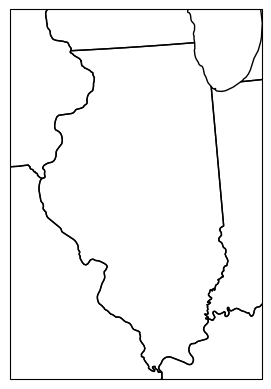

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.set_extent([-92, -87, 37, 43])

ax.add_feature(cfeature.STATES)

### Chapter 7.3.2 -Choropleth Maps

[Choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map) are maps that can visualize relative frequencies of events within certain geometries. For example, the Storm Prediction Center has created maps that show the average count of tornadoes per state. The colormap helps the reader identify the relatively active states (deep red) with the less active states (white). This can be a more useful tool than just providing a table.

<img src=https://www.spc.noaa.gov/wcm/ustormaps/1995-2014-stateavgtornadoes.png></img>

**Spatial Join Applications**

Choropleth maps require spatial joins to calculate the number of events within geometric bounds. In our case, we want to count the number of tornado reports that are within each state. This is just an extension of the problem above. We found that 110 tornadoes occurred within 40 km of NIU from 1950 - 2024 (75 years). We can then say that this region experiences about 1.5 tornadoes per year (110 tornadoes / 75 years = 1.47 t/yr), or 3 tornadoes every 2 years.

We first need to access the geometry of the states. We can easily do this through the cartopy interface. We can do some filtering to get to the CONUS. We also can see that the projection is lat/lon.





/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


states projection = EPSG:4326


<Axes: >

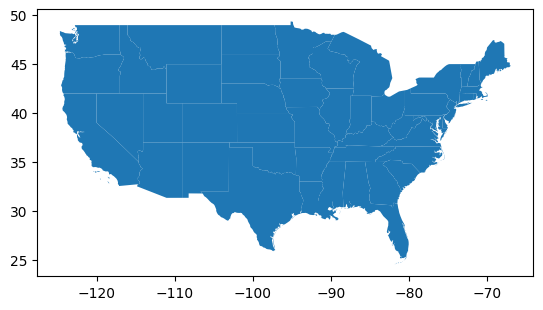

In [18]:
import cartopy.io.shapereader as shpreader

states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_1_states_provinces')

states = gpd.read_file(states_shp)

# only USA
states = states[states.admin=="United States of America"]

# remove AK, HI, PR
states = states[~states.name.isin(['Alaska', "Hawaii", 'Puerto Rico'])]

print("states projection =", states.crs)
states.plot()

If we want to spatially join the US states with the tornado reports, we need to project these to albers:

<Axes: >

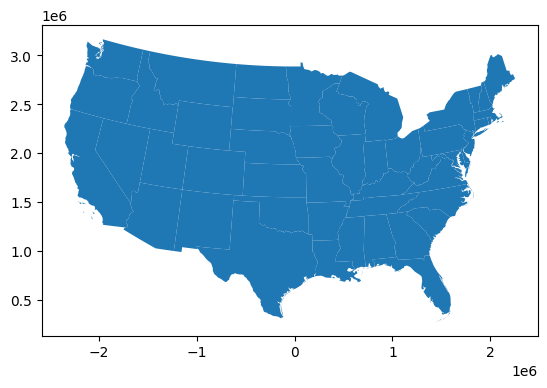

In [19]:
states_aea = states.to_crs("EPSG:5070")

states_aea.plot()

Next, we can try an left spatial join on the two datasets because most of the data will be matched (since most reports are in the CONUS) and we are just looking for counts.

NOTE: I have limited the columns for each dataset for illustrative purposes.

You can see that due to the left join and the position of the input `GeoDataFrame`, the `geometry` from the tornado reports are kept, but the state `geometry` is gone (*think about this*: how can you tell?).

The new columns, `index_right` and `name`, tell us to which polygon each report belongs.

In [20]:
choro = gpd.sjoin(
    tor_aea[['om', 'date', 'time', 'mag', 'geometry']],
    states_aea[['name', 'geometry']],
    how='left',
    predicate='within'
)

print("length of original dataset", len(tor_aea))
print("length of choro dataset", len(choro))
choro

length of original dataset 71813
length of choro dataset 71813


,om,date,time,mag,geometry,index_right,name
0,192,1950-10-01,21:00:00,1,POINT (-576429.91 1540286.361),85.0,Oklahoma
1,193,1950-10-09,02:15:00,3,POINT (1583114.194 1379312.919),76.0,North Carolina
2,195,1950-11-20,02:20:00,2,POINT (770870.952 1627934.009),66.0,Kentucky
3,196,1950-11-20,04:00:00,1,POINT (995139.521 1745526.248),66.0,Kentucky
4,197,1950-11-20,07:30:00,1,POINT (642127.922 1061814.299),74.0,Mississippi
...,...,...,...,...,...,...,...
71808,624887,2024-09-07,05:58:00,-9,POINT (746005.01 2113082.019),64.0,Indiana
71809,624888,2024-09-09,14:19:00,0,POINT (-978435.715 2357756.7),99.0,Wyoming
71810,624889,2024-09-09,14:33:00,0,POINT (1369712.872 2349186.361),83.0,New York
71811,624890,2024-09-09,15:15:00,-9,POINT (1601330.401 2477276.772),83.0,New York


We can see repeats, which means that we can count the number of times each `index_right` shows up in the dataset using a `groupby.size`:

In [21]:
state_counts = choro.groupby('index_right').count()[['om']]
state_counts = state_counts.rename({'om': 'counts'}, axis=1)

state_counts

,counts
index_right,
50.0,2576
51.0,2037
52.0,291
53.0,467
54.0,2463
55.0,122
56.0,3
57.0,72
58.0,3261


Now we can attach the counts using `join`. In this case, only one of the joined tables has `geometry`, so we want that table (`states_aea`) to be on the left side of the `join` method. The result is a new column named 'counts' attached to the right side of the states shapefile information. This retains all of the original states geometry.

In [22]:
states_aea_count = states_aea.join(state_counts)

# only show these columns for illustrative purposes
states_aea_count[['name', 'counts', 'geometry']]

,name,counts,geometry
50.0,Alabama,2576,"MULTIPOLYGON (((815418.637 847840.206, 813244...."
51.0,Arkansas,2037,"POLYGON ((561988.371 1457534.294, 561720.128 1..."
52.0,Arizona,291,"POLYGON ((-1233439.534 1001748.268, -1254762.9..."
53.0,California,467,"MULTIPOLYGON (((-1674020.359 1490246.147, -167..."
54.0,Colorado,2463,"POLYGON ((-1146579.255 1629679.09, -1142743.45..."
55.0,Connecticut,122,"POLYGON ((1968992.971 2364305.278, 1970547.927..."
56.0,District of Columbia,3,"POLYGON ((1619304.787 1924651.24, 1616815.677 ..."
57.0,Delaware,72,"POLYGON ((1797409.178 1912932.815, 1788400.686..."
58.0,Florida,3261,"MULTIPOLYGON (((815418.637 847840.206, 815978...."
59.0,Georgia,1913,"MULTIPOLYGON (((1044304.337 941118.548, 103713..."


We can now create an interactive choropleth map through `Geopandas` plotting interface and `explore`.

In [24]:
states_aea_count.explore(column='counts', popup=False, tooltip='counts')

**Your Turn**: Get into a small group and use the documentation of the [`explore`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) function to customize a map that:

- Has a title
- Has a scale bar
- Has a legend
- Has a colormap similar to the map example
- Only considers tornadoes between 1991 - 2020
- Adjusts the counts for each state by the number of years to get a per-year count


If you complete that, make a map that adjusts the per-year counts by the area of the shape to get counts per year per 10,000 sq. miles.

<img src=https://www.spc.noaa.gov/wcm/ustormaps/1995-2014-tornadoes-per10k-perstate.png></img>

If you complete that, make a map of fatalities per state. Note that you do not need a spatial join for this one, but you might need to change the approach.

<img src=https://www.spc.noaa.gov/wcm/ustormaps/1995-2014-stateavgfatals.png></img>